# Vertical deflection in a Kirchhoff-Love Plate, using firedrake

The goal of this notebook is to treat an ice shelf as a rectangular thin plate, load it with some surface accumulation, and calculate the vertical elastic deflection. This notebook references a 2007 text by Dietrich Braess, as well as [MacAyeal et al., 2021](https://www.cambridge.org/core/journals/journal-of-glaciology/article/treatment-of-iceshelf-evolution-combining-flow-and-flexure/AD266BB055752B4DC817FEAAA86363A3).

In [1]:
from firedrake import *
import matplotlib.pyplot as plt

Begin by exressing the variational form for linear elasticity as a minimization problem for the energy $\Pi$ (3.1 from Deitrich Braess):

$$\Pi(\vec{u}, \vec{v}) = \int_\Omega\left(\vec{\sigma}(\vec{u}):\vec{\varepsilon}(\vec{v})\right)d\Omega - \int_{\Gamma_t}\left((\vec{\sigma}(\vec{u})\cdot\vec{n}\right)\cdot\vec{v}d\Gamma_t - \int_\Omega\vec{f}\cdot\vec{v}d\Omega.$$

This will be simplified using the constitutive relation for plane strain, under Kirchhoff's Hypothesis (see below). I'll write this relationship first using vector notation, since it allows easier comparison with MacAyeal et al., 2021, and then using tensor notation (since tensor notation works best with Firedrake). 


## Constitutive relation: vector notation 

The deflection vector $\vec{u}$ has components $u_x$, $u_y$, and $u_z := \eta$ ($\eta$ being depth-invariant by assumption). In this case, we use Kirchhoff's Hypothesis to write the horizontal deflections in terms of the vertical deflection, with $u_x = -\zeta\frac{\partial\eta}{\partial x}$ and $u_y = -\zeta\frac{\partial\eta}{\partial y}$ ($\zeta$ the vertical coordinate of the middle of the plate). Calculating the resulting strains, we find that the terms $\varepsilon_{xz}$, $\varepsilon_{yz}$, and $\varepsilon_{zz}$ disappear, and the remaining strains can be compactly expressed as (Eq. 5.3):

$$\vec{\varepsilon} = \begin{bmatrix}\varepsilon_{xx}\\ \varepsilon_{yy}\\ \varepsilon_{xy}\end{bmatrix} = -\zeta\begin{bmatrix}\frac{\partial^2\eta}{\partial x^2} \\ \frac{\partial^2\eta}{\partial y^2}\\ \frac{\partial^2\eta}{\partial x\partial y}\end{bmatrix} = -\zeta\begin{bmatrix}\frac{\partial^2}{\partial x^2} \\ \frac{\partial^2}{\partial y^2} \\ \frac{\partial^2}{\partial x\partial y}\end{bmatrix}\eta.$$

By Equation 4.3, the elimination of $\varepsilon_{zz}$ allows us to use the plane-strain approximation as the constitutive relation:

$$\vec{\sigma} = \begin{bmatrix}\sigma_{xx} \\ \sigma_{yy} \\ \sigma_{xy} \end{bmatrix} = \frac{E}{1 - \mu^2}\begin{bmatrix}1 & \mu & 0\\
\mu & 1 & 0\\
0 & 0 & 1 - \mu\end{bmatrix}\vec{\varepsilon} = -\zeta\frac{E}{1 - \mu^2}\begin{bmatrix}1 & \mu & 0\\
\mu & 1 & 0\\
0 & 0 & 1 - \mu\end{bmatrix}\begin{bmatrix}\frac{\partial^2\eta}{\partial x^2}\\
\frac{\partial^2\eta}{\partial y^2} \\ \frac{\partial^2\eta}{\partial x\partial y}\end{bmatrix}$$

As a side note, the bending moment can now be computed by multiplying both sides by $\zeta$ and integrating vertically from $-\frac{H}{2}$ to $\frac{H}{2}$. This procedure reproduces Eq. 34 from MacAyeal et al. (2021), using vector notation. 

## Constitutive relation: tensor notation

Alternatively, the equations above can be rewritten in tensor notation so that:

$$\vec{\varepsilon} = \begin{bmatrix}\varepsilon_{xx} & \varepsilon_{xy}\\
\varepsilon_{xy} & \varepsilon_{yy}
\end{bmatrix} = -\zeta\begin{bmatrix}\frac{\partial^2\eta}{\partial x^2} & \frac{\partial^2\eta}{\partial x\partial y}\\
\frac{\partial^2\eta}{\partial x\partial y} & \frac{\partial^2\eta}{\partial y^2}
\end{bmatrix} = -\zeta\nabla^2\eta$$

and (Eq. 4.3 from Dietrich Braess)

$$\vec{\sigma} = \begin{bmatrix} \sigma_{xx} & \sigma_{xy} \\
\sigma_{xy} & \sigma_{yy}
\end{bmatrix} = \frac{E}{1 + \mu}\left(\vec{\varepsilon} + \frac{\mu}{1 - \mu}tr(\vec{\varepsilon})\vec{I}\right) = -\zeta\frac{E}{1 + \mu}\left(\nabla^2\eta + \frac{\mu}{1 - \mu}tr(\nabla^2\eta)\vec{I}\right).$$

I've verified term-by-term that this is equivalent to the representation given above. I'll somewhat arbitrarily use the following values for Poisson's ratio $\mu$ and Young's Modulus $E$:

In [2]:
E = 1e15 #Pacals. Suggested value by MacAyeal et al. is 1e9, but this results in unrealistically large deflections
μ = 1/3

## Simplifying the variational form

Using tensor notation, and writing $\vec{v} = \begin{bmatrix}v_x & v_y & v\end{bmatrix}^T$, the variational form, written previously, becomes

$$\Pi(\vec{u}, \vec{v}) = \Pi(\eta, v) =  \frac{E}{1 + \mu}\int_\Omega\left[-\zeta\left(\nabla^2\eta + \frac{\mu}{1 - \mu}tr(\nabla^2\eta)\vec{I}\right):-\zeta\nabla^2v\right]d\Omega - \int_{\Gamma_t}(\vec{\sigma}\cdot\vec{n})\cdot\vec{v}d\Gamma_t - \int_\Omega f(x, y)v(x, y)d\Omega =$$

$$= \frac{E}{1 + \mu}\int_\Omega\left[\zeta^2\left(\nabla^2\eta + \frac{\mu}{1 - \mu}tr(\nabla^2\eta)\vec{I}\right):\nabla^2v\right]d\Omega - \int_{\Gamma_t}(\vec{\sigma}\cdot\vec{n})\cdot\vec{v}d\Gamma_t - \int_\Omega f(x, y)v(x, y)d\Omega.$$

Vertically integrating the first and third terms on the right from $-\frac{H}{2}$ to $\frac{H}{2}$, and introducing the shorthand $\lambda_1 := \frac{E}{1 + \mu}$ and $\lambda_2 := \frac{E}{1 + \mu}\left(\frac{\mu}{1 - \mu}\right)$, the variational form simplifies to

$$ \Pi(\eta, v) = \lambda_1\frac{H^3}{12}\int_{x, y}\nabla^2\eta : \nabla^2 v dxdy + \lambda_2\frac{H^3}{12}\int_{x, y}tr(\nabla^2\eta)\vec{I} : \nabla^2 vdxdy - \int_{\Gamma_t}(\vec{\sigma}\cdot\vec{n})\cdot\vec{v}d\Gamma_t - H\int_{x, y}f(x, y)v(x, y)dxdy.$$

In [3]:
λ_1 = E/(1 + μ)
λ_2 = λ_1*μ/(1 - μ)

Noting finally that $tr(\nabla^2\eta)\vec{I} : \nabla^2 v = \Delta\eta\Delta v$ ($\Delta$ the Laplacian operator, which takes the divergence of the gradient), the form to be minimized is

$$\Pi(\eta, v) = \lambda_1\frac{H^3}{12}\int_{x, y}\nabla^2\eta : \nabla^2 v dxdy + \lambda_2\frac{H^3}{12}\int_{x, y}\Delta\eta\Delta vdxdy - \int_{\Gamma_t}(\vec{\sigma}\cdot\vec{n})\cdot\vec{v}d\Gamma_t - H\int_{x, y}f(x, y)v(x, y)dxdy.$$

## Spatial extent and mesh

In [4]:
nx, ny = 40, 20
Lx, Ly = 10000, 5000 #5 km long by 1 km wide shelf
mesh = RectangleMesh(nx, ny, Lx, Ly)

x, y = SpatialCoordinate(mesh)
Q = FunctionSpace(mesh, 'Argyris', 5)

## Physical parameters

In [5]:
#constants
ρ_i = 917 #ice density in kg/m^3
ρ_w = 1018 #saltwater density in kg/m^3
g = 9.81 #g 

#thickness, velocity, velocity gradients
H = 100 #shelf thickness in meters
u = project(Constant(0), Q) #initial velocity field as a placeholder value. We'll solve for this, eventually
du_dx = grad(u)[0] #du/dx

#viscosity
T = Constant(273.15) #temperature (K). 273.15 is freezing
from icepack import rate_factor
A = rate_factor(T)
ν = 1/2*A**(-1/3) #ice viscosity (note the symbol nu, as opposed to v introduced below)

i = as_vector([1, 0])
j = as_vector([0, 1])

## Trial and test functions, and their gradients

In [6]:
#trial function η and its gradients
η = Function(Q) #the deflection to be solved for
ddη = grad(grad(η)) #∇^2(η)
Δη = div(grad(η)) #the laplacian of η

#bending moments and their gradients
M = H**3/12*(λ_1*ddη + λ_2*tr(ddη)*Identity(2)) #M as a tensor. Evaluated by integrating ζσ from -H/2 to H/2.
Mxx_xx = grad(grad(M[0, 0]))[0, 0] #the second x-derivative of Mxx: d^2(M_xx)/dx^2
Myy_yy = grad(grad(M[1, 1]))[1, 1] #the second y-derivative of Myy: d^2(M_yy)/dy^2
Mxy_xy = grad(grad(M[0, 1]))[0, 1] #d^2(M_xy)/dxdy

#test function and its gradients
v = TestFunction(Q)
ddv = grad(grad(v))
Δv = div(grad(v)) #the laplacian of v

## Choose some physical forcing to bend the shelf

We can find examples of various loads in Eq. 57 of MacAyeal et al. For example, there will be a downward force associated with any surface accumulation, $H_s$ (see Eq. 57c). I'll impose an artificial surface accumulation of one meter at the upstream boundary, linearly decreasing to zero at the downstream boundary, alongside a couple other terms from Eq. 57:

Text(0, 0.5, 'lateral coordinate (m)')

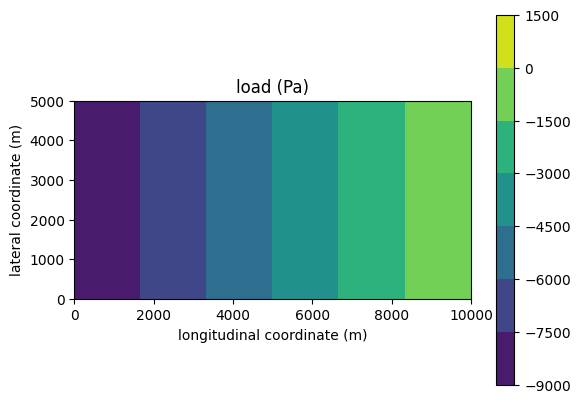

In [7]:
Hs = 1e-4*(Lx - x) #surface accumulation in meters, as a function of x

f_a = -ρ_w*g*η #Eq. 57a: restorative force of buoyancy, acting opposite the sign of η
f_c = -ρ_i*g*Hs #Eq. 57c: weight as a function of surface accumulation
f_e = H*(ν*du_dx - 1/2*ρ_i*g*H)*ddη[0, 0] #Eq. 57e: ice shelf flow contribution 

F = project(f_a + f_c + f_e, Q) #total load on the plate

fig, ax = plt.subplots() #and plot it
ax.set_aspect('equal')
load = tricontourf(F, axes=ax)
plt.colorbar(load)
plt.title('load (Pa)')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')

## Set up the problem to be solved

We need to minimize the expression:

$$\Pi(\eta, v) = \lambda_1\frac{H^3}{12}\int_{x, y}\nabla^2\eta : \nabla^2 v dxdy + \lambda_2\frac{H^3}{12}\int_{x, y}\Delta\eta\Delta vdxdy - \int_{\Gamma_t}(\vec{\sigma}\cdot\vec{n})\cdot\vec{v}d\Gamma_t - H\int_{x, y}f(x, y)v(x, y)dxdy$$

subject to the constraint that (Eq. 46 from MacAyeal et al.):

$$\frac{\partial^2M_{xx}}{\partial x^2} + 2\frac{\partial^2M_{xy}}{dxdy} + \frac{\partial^2M_{yy}}{\partial y^2} + f = 0,$$

where $M$ relates to $\nabla^2\eta$ as specified two cells above. I'll also impose no-slip boundary conditions at the sidewalls, so that $\eta = 0$ on boundaries 3 and 4. All constraints will be enforced via the penalty method.

In [8]:
L = (λ_1*(H**3)/12*inner(ddη, ddv) + λ_2*(H**3)/12*Δη*Δv - H*F*v)*dx

######################################
######################################
### What value should I use for α? ###
######################################
######################################

α = 1e10 
L += 0.5*α**2*(η*v)*ds(3) #η = 0 on boundary 3
L += 0.5*α**2*(η*v)*ds(4) #η = 0 on boundary 4

#####################################################
#####################################################
### Why does this additional constraint not work? ###
#####################################################
#####################################################

#L += 0.5*α**2*((Mxx_xx + 2*Mxy_xy + Myy_yy)*v + F*v)*dx #balance of forces on Ω

## Solve and plot

Text(0, 0.5, 'lateral coordinate (m)')

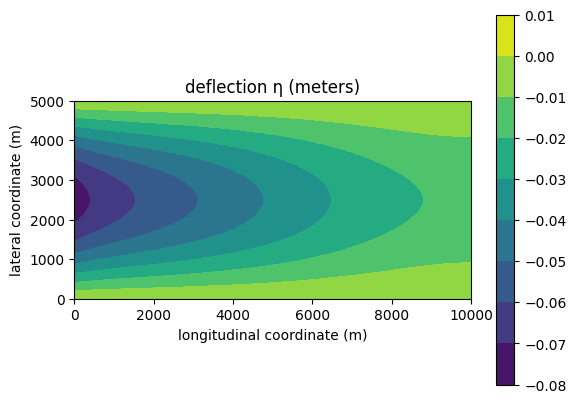

In [9]:
solve(L == 0, η)

fig, ax = plt.subplots()
ax.set_aspect('equal')
colors = tricontourf(η, axes = ax)
plt.colorbar(colors)
plt.title('deflection η (meters)')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')

## Original code from June 21st meeting
```
nx, ny = 16, 16
mesh = UnitSquareMesh(nx, ny, diagonal = 'crossed')
element = FiniteElement('Argyris', 'triangle', 5) 
Q = FunctionSpace(mesh, element) 

x = SpatialCoordinate(mesh)
R = Constant(0.25)
ξ = Constant((0.5, 0.5))
f = -exp(-inner(x - ξ, x-ξ)/R**2) #downward force on the plate
F = project(f, Q)

fig, ax = plt.subplots()
force = tricontourf(F, axes=ax)
plt.colorbar(force)

μ = Constant(1.0)
λ = Constant(1.0)

η = Function(Q)
v = TestFunction(Q)

ddη = grad(grad(η))
ddv = grad(grad(v))
Δη = div(grad(η)) #the laplacian of w
Δv = div(grad(v)) #laplacian of v

h = CellSize(mesh)
L_1 = (μ*inner(ddη, ddv) + λ*Δη*Δv - F*v)*dx
L_2 = (μ + λ)*(η*v)/h**3*ds 
L_3 = (μ+λ)*h*inner(ddη, ddv)*ds

L = L_1 + L_2 + L_3

solve(L == 0, η)

fig, ax = plt.subplots()
ax.set_aspect('equal')
colors = tricontourf(η, axes = ax)
plt.colorbar(colors)
```